In [1]:
import wandb

In [2]:
wandb.init(project="lunarLander(26_11)", entity = "rl_proj")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 1630423 (rl_proj). Use `wandb login --relogin` to force relogin


In [3]:
import gymnasium as gym
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from utils_lunarlander import *

os.makedirs("outputs", exist_ok=True)

DEVICE = "cpu"
ACTION_SPACE = [0, 1, 2, 3]
EPISODES = 10000
BATCH_SIZE = 8
GAMMA = 0.99
RENDER = False
SAVE_INTERVAL = 100  # Save model every 100 episodes
PRINT_INTERVAL = 100  # Print information every 50 episodes
MAX_STEPS_PER_EPISODE = 100 #maximum steps for each episode

class ReinforceNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(ReinforceNetwork, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, n_outputs)

    def forward(self, x):
        x = x.unsqueeze(0) if x.dim() == 1 else x
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        actions = torch.softmax(self.fc3(x), dim=-1)
        action = self.get_action(actions)
        log_prob_action = torch.log(actions.squeeze(0))[action]
        return action, log_prob_action

    def get_action(self, actions):
        return np.random.choice(ACTION_SPACE, p=actions.squeeze(0).detach().cpu().numpy())

env = gym.make("LunarLander-v2")
model = ReinforceNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

all_rewards = []
all_losses = []
batch_rewards = []
batch_log_probs = []
best_rolling = -99999

for episode in range(EPISODES):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=DEVICE)  # Convert state to tensor
    episode_rewards = []
    episode_log_probs = []

    for step in range(MAX_STEPS_PER_EPISODE):
        if RENDER:
            env.render()

        action, log_prob = model(state)
        step_result = env.step(action)
        state, reward, done, info = step_result[:4]
        state = torch.tensor(state, dtype=torch.float32, device=DEVICE)  # Convert next state to tensor

        episode_log_probs.append(log_prob)
        episode_rewards.append(reward)  # Removed reward scaling

        if done:

          break

    total_reward = np.sum(episode_rewards)
    all_rewards.append(total_reward)
    rolling_avg_reward = pd.Series(all_rewards).tail(100).mean()

    if (episode + 1) % PRINT_INTERVAL == 0:

        print(f"EPISODE {episode} SCORE: {total_reward} roll: {rolling_avg_reward}")

    if rolling_avg_reward > best_rolling:
        best_rolling = rolling_avg_reward
        #print("Saving model...")
        torch.save(model.state_dict(), f'/workspaces/RL_Project/LunarLander/outputs/best_parameters_26_11.pth')

    batch_rewards.extend(episode_rewards)
    batch_log_probs.extend(episode_log_probs)

    if (episode + 1) % BATCH_SIZE == 0 or episode == EPISODES - 1:
        discounted_rewards = []
        Gt = 0
        for reward in reversed(batch_rewards):
            Gt = reward + GAMMA * Gt
            discounted_rewards.insert(0, Gt)

        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32, device=DEVICE)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
        batch_log_probs = torch.stack(batch_log_probs)

        policy_gradient = -batch_log_probs * discounted_rewards

        optimizer.zero_grad()
        loss = policy_gradient.sum()
        loss.backward()
        optimizer.step()

        all_losses.append(loss.item())
        batch_rewards = []
        batch_log_probs = []



env.close()


EPISODE 99 SCORE: -93.064384306536 roll: -180.5333503932608
EPISODE 199 SCORE: -107.73046263276844 roll: -147.9931666784694
EPISODE 299 SCORE: -84.61666584830091 roll: -121.06651338604759
EPISODE 399 SCORE: -65.7858173898891 roll: -114.2928821098591
EPISODE 499 SCORE: -83.14294847312966 roll: -101.58425232926578
EPISODE 599 SCORE: -82.00591184246629 roll: -78.45494935225625
EPISODE 699 SCORE: -15.519925647141061 roll: -48.65499311596486
EPISODE 799 SCORE: -64.81156418208714 roll: -27.645914219767125
EPISODE 899 SCORE: 76.46069828344747 roll: -10.011099796692212
EPISODE 999 SCORE: 66.487111772405 roll: 16.912601105948447
EPISODE 1099 SCORE: 40.697713460244444 roll: 50.58122040716551
EPISODE 1199 SCORE: -6.816134899313163 roll: 46.10064342006233
EPISODE 1299 SCORE: 33.001945266296964 roll: 52.22615506575316
EPISODE 1399 SCORE: 96.44706270463068 roll: 64.25296203511225
EPISODE 1499 SCORE: 38.77268237523788 roll: 56.72801128500623
EPISODE 1599 SCORE: 81.11851186543325 roll: 60.019595348786

### Plots

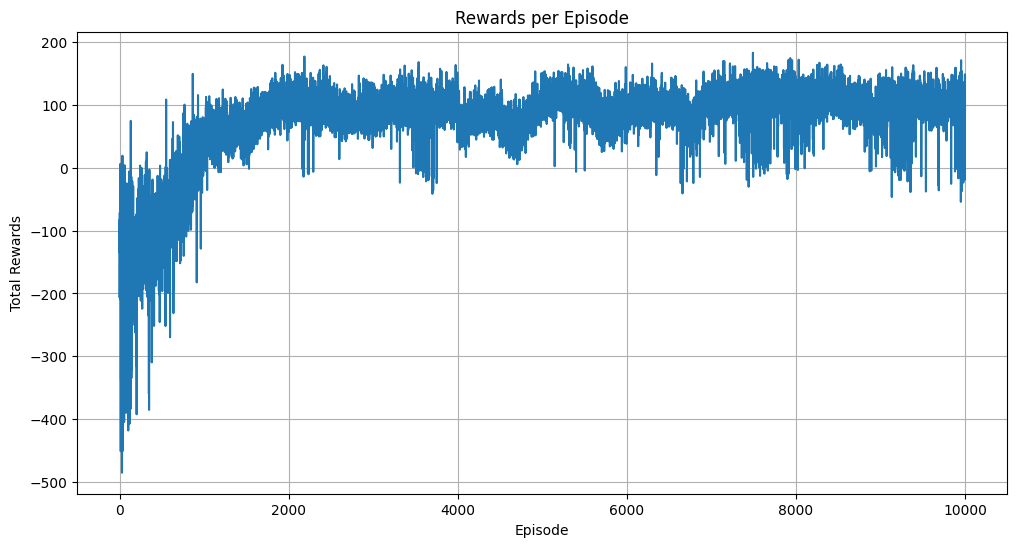

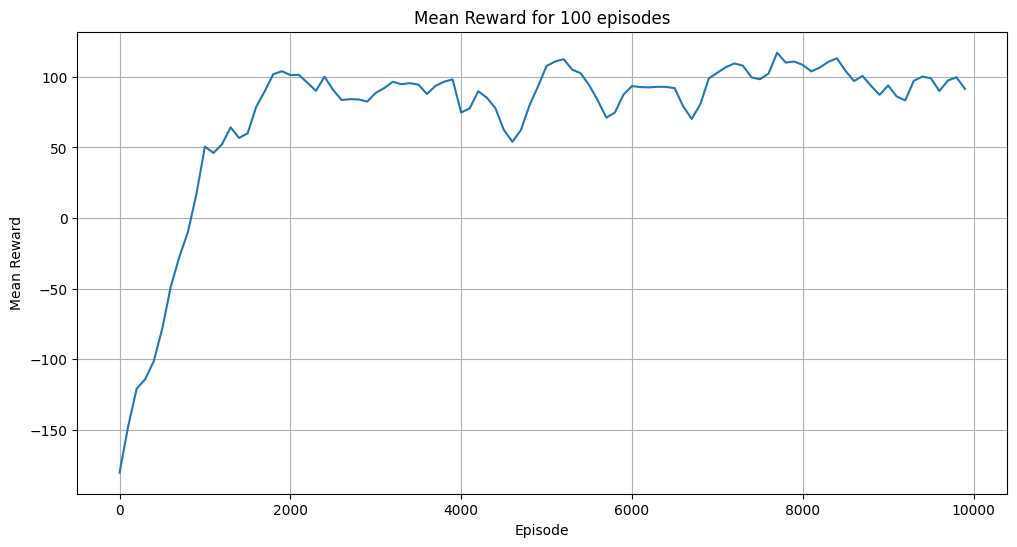

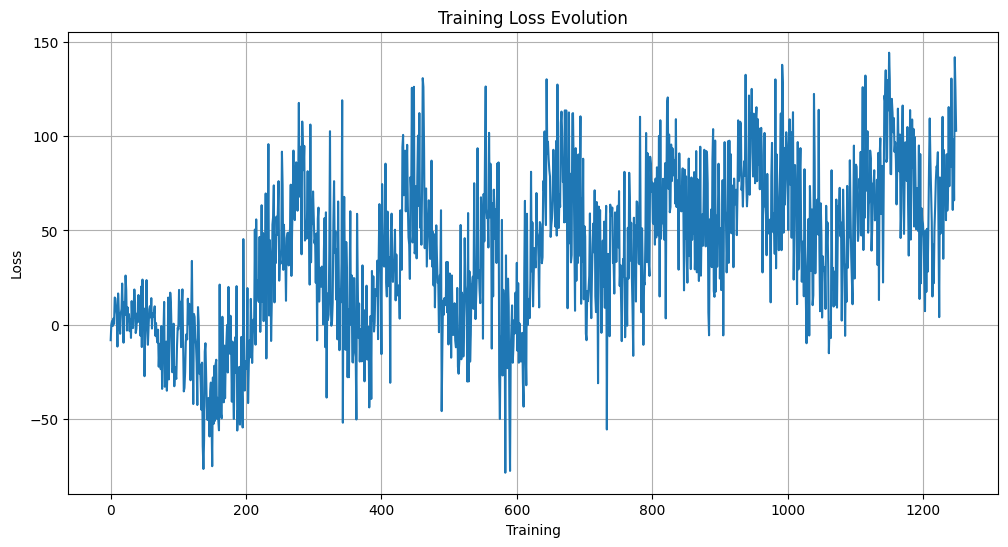

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [4]:
plot_loses (all_rewards, all_losses)